# New Jersey County Zillow Analysis

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings('ignore')

## Business Problem

 - A real estate investment firm is interested in knowing the top three New Jersey counties to invest in based on return on investment (ROI). This notebook will analyze past ROI data in order to compare with future forecasted ROI predictions. The model used for predicting future ROI will be a SARIMA model, which takes into account the seasonal nature of the real estate market. The data will then be broken out by county and will use a stepwise fit to find optimal model orders in order to minimize AIC and produce the most accurate model based on the data. The SARIMA models will then be fitted and will forecast 5 years into the future. The models will then be analyzed taking into account RMSE as an evaluation metric. The top three counties will then be reccomended based on these methods, as well as the main counties to avoid, and the county with the lowest initial investment.     

## Load Data for Analysis

In [2]:
df = pd.read_csv('data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.shape

(14723, 272)

## Data Description

 - The data used in this notebook will be Zillow home data ranging from April 1st, 1996 through April 1st, 2018. The data contains home value information from the United States consisting of 14,723 columns and 272 rows. For the purposes of this project the data will be filtered to only include New Jersey data. The New Jersey data will then be seperated out by individual county in order to model each county for forecasted ROI. The data will also be grouped by month for a mean value of homes for each month. The data will first need to be converted into datetime objects in order to prepare it for time series modeling. The data will also need to be converted from wide to long format in order to make it easier to work with and interperet. 

## Data Preprocessing

In [5]:
#Convert date columns to datetime objects
def get_datetimes(df):
    non_dt_cols = []
    dt_cols = []
    
    for c in df.columns:
        if c[0].isnumeric():
            dt_cols.append(c)
        else:
            non_dt_cols.append(c)
    dt_cols = list(pd.to_datetime(dt_cols, format = '%Y-%m'))
    
    df.columns = non_dt_cols + dt_cols
    return df

In [6]:
df = get_datetimes(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## EDA and Visualization

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

## Reshape from Wide to Long Format

In [8]:
#Function to melt dataframe with datetime columns
def melt_data(df):
    melted = pd.melt(
        df,
        id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
        var_name='time')
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
#Updated dataframe
melted_df = melt_data(df)
melted_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [10]:
#Melted dataframe info
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   RegionName  int64         
 2   City        object        
 3   State       object        
 4   Metro       object        
 5   CountyName  object        
 6   SizeRank    int64         
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


## Functions

In [63]:
def plot_values(df, title):
    """Takes in a dataframe and grpah title, plots the average annual home values of the dataframe."""
    df.resample(rule='A').mean().plot(figsize=(15,5))
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Value US$')
    plt.title(title);

In [12]:
#Function to help interpret Dickey-Fuller test results
def adfuller_of(series):
    """Prints the Augmented Dickey-Fuller test results."""
    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                          ADF: {adf}
                      P-Value: {pvalue}
                     Used Lag: {usedlag}
       Number of Observations: {nobs}
    Critical Values (for ADF): {crit_vals}
                  ResultStore: {resstore}
    ''')

In [13]:
def get_roi(df):
    """Calculate return on investment from a datframe."""
    resampled_df = df.resample(rule='A').mean()
    cost = resampled_df.iloc[0,0]
    value = resampled_df.iloc[-1,0]
    ROI = (value-cost)/cost
    print(f'1996-2018 Return on Investment: {round(ROI, 2)}')

In [14]:
def county_df(county):
    """Create seperate county dataframes from NJ dataframe."""
    county_df = nj_df[(nj_df['CountyName'] == county)]
    return county_df

In [15]:
def get_roi_dict(state_df):
    """Takes in a state dataframe and returns a dictionary of past ROI by county."""
    roi_lst = []
    for c in state_df.CountyName.unique():
        county_df = state_df[(state_df['CountyName'] == c)]
        resampled_df = county_df.resample(rule='A').mean()
        cost = resampled_df.iloc[0,0]
        value = resampled_df.iloc[-1,0]
        ROI = (value-cost)/cost
        roi_lst.append(round(ROI,2))
    unique_counties = []
    for county in state_df.CountyName.unique():
        unique_counties.append(county)
        
    roi_dict = dict(zip(unique_counties, roi_lst))
    return(roi_dict)

In [16]:
def sarima_model_fcast(state_df):
    """Takes in a state dataframe, runs a stepwise fit and SARIMA model on each county and returns a dictionary of forecasted ROI for each county."""
    forcasted_roi = []
    for c in state_df.CountyName.unique():
        county_df = state_df[(state_df['CountyName'] == c)]
        monthly_df = county_df.resample(rule='M').mean()
        stepwise_fit = auto_arima(monthly_df['value'])
        model_order = stepwise_fit.order
        train = monthly_df.iloc[:253]
        test = monthly_df.iloc[253:]
        model = SARIMAX(train['value'], order=model_order)
        results = model.fit()
        start = len(train)
        end = len(train) + len(test) - 1
        predictions = results.predict(start, end, typ='levels')
        error = rmse(test['value'], predictions)
        future_model = SARIMAX(monthly_df['value'], order=model_order)
        results_future = future_model.fit()
        fcast = results_future.predict(len(monthly_df), len(monthly_df)+60, typ='levels')
        fcast_df = pd.DataFrame(fcast)
        cost = fcast_df.iloc[0,0]
        value = fcast_df.iloc[-1,0]
        ROI = (value-cost)/cost
        forcasted_roi.append(round(ROI,2))
        
    unique_counties = []
    for county in state_df.CountyName.unique():
        unique_counties.append(county)
            
    roi_dict = dict(zip(unique_counties, forcasted_roi))
    
    return roi_dict

In [17]:
def sarima_model_rmse(state_df):
    """Takes in a state dataframe, runs a stepwise fit and SARIMA model on each county and returns a dictionary of the RMSE for each county."""
    rmse_lst = []
    for c in state_df.CountyName.unique():
        county_df = state_df[(state_df['CountyName'] == c)]
        monthly_df = county_df.resample(rule='M').mean()
        stepwise_fit = auto_arima(monthly_df['value'])
        model_order = stepwise_fit.order
        train = monthly_df.iloc[:253]
        test = monthly_df.iloc[253:]
        model = SARIMAX(train['value'], order=model_order)
        results = model.fit()
        start = len(train)
        end = len(train) + len(test) - 1
        predictions = results.predict(start, end, typ='levels')
        error = rmse(test['value'], predictions)
        rmse_lst.append(round(error,))
        
    unique_counties = []
    for county in state_df.CountyName.unique():
        unique_counties.append(county)
      
    rmse_dict = dict(zip(unique_counties, rmse_lst))    
    
    return rmse_dict

In [85]:
def fcast_plot(county_df, title):
    """Takes in a county dataframe and graph title, returns a graph of the 5-year county forecast."""
    monthly_df = county_df.resample(rule='M').mean()
    stepwise_fit = auto_arima(monthly_df['value'])
    model_order = stepwise_fit.order
    train = monthly_df.iloc[:253]
    test = monthly_df.iloc[253:]
    start = len(train)
    end = len(train) + len(test) - 1
    future_model = SARIMAX(monthly_df['value'], order = model_order)
    results_future = future_model.fit()
    fcast = results_future.predict(len(monthly_df), len(monthly_df)+60, typ='levels').rename('SARIMA Forecasted Value')
    return monthly_df['value'].plot(legend=True, label='Actual Mean Home Value', figsize=(12,8)), fcast.plot(legend=True), plt.grid(), plt.title(title), plt.xlabel('Year'), plt.ylabel('Value US$')


In [19]:
def model_accuracy(county_df, title):
    monthly_df = county_df.resample(rule='M').mean()
    stepwise_fit = auto_arima(monthly_df['value'])
    model_order = stepwise_fit.order
    train = monthly_df.iloc[:253]
    test = monthly_df.iloc[253:]
    start = len(train)
    end = len(train) + len(test) - 1
    future_model = SARIMAX(monthly_df['value'], order = model_order)
    results_future = future_model.fit()
    predictions = results_future.predict(start, end, typ='levels')
    return test['value'].plot(legend=True,label='Actual Mean Home Value',figsize=(12,8)), predictions.plot(legend=True,label='SARIMA Predicted Mean Home Value'), plt.title(title), plt.xlabel('May 2017 - April 2018'), plt.ylabel('Value US$'), plt.grid()

## Seperate New Jersey Data

In [20]:
#Select NJ data for analysis
nj_df = melted_df[melted_df['State'] == 'NJ']
nj_df.set_index('time', inplace=True)

In [21]:
nj_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0
1996-04-01,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0
1996-04-01,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0


In [22]:
nj_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133030 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    133030 non-null  int64  
 1   RegionName  133030 non-null  int64  
 2   City        133030 non-null  object 
 3   State       133030 non-null  object 
 4   Metro       133030 non-null  object 
 5   CountyName  133030 non-null  object 
 6   SizeRank    133030 non-null  int64  
 7   value       133030 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 9.1+ MB


 - The data contains no missing values.
 - Will change 'RegionID, RegionName, and 'SizeRank' columns to strings.

In [23]:
#Change columns from int64 to string
nj_df['RegionID'] = nj_df['RegionID'].astype(str)
nj_df['RegionName'] = nj_df['RegionName'].astype(str)
nj_df['SizeRank'] = nj_df['SizeRank'].astype(str)

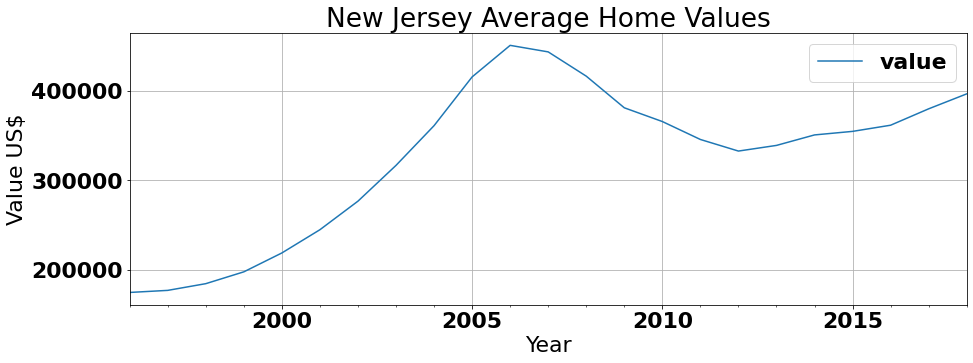

In [64]:
#Plot NJ average home values
plot_values(nj_df, 'New Jersey Average Home Values')

 - Overall New Jersey home values appear to have sharply increased from 1996 through around 2006 before significantly dropping in value from 2008 to around 2012. This is likely due to the housing crisis and recession starting in 2008. Since around 2012 home values appear to be steadily increasing across the state as the economy began to steadily improve during this time period. Overall the data does not appear to be stationary as it follows a general upward trend.

In [25]:
#Perfrom Dickey-Fuller test to check for stationarity
#adfuller_of(nj_df['value'])

 - Adfuller test shows a p-value of 2.55. This is above the .05 threshold, meaning we can reject the accept the null hypothesis that the data is not stationary. 

In [26]:
#Resample NJ data by month
nj_monthly = nj_df.resample(rule='M').mean()

In [27]:
#Run a seasonal decomposition to check from trends, seasonality, and residual values
decomposition = seasonal_decompose(nj_monthly['value'])

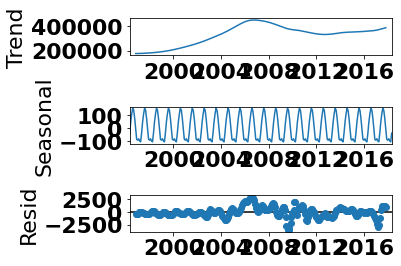

<Figure size 432x288 with 0 Axes>

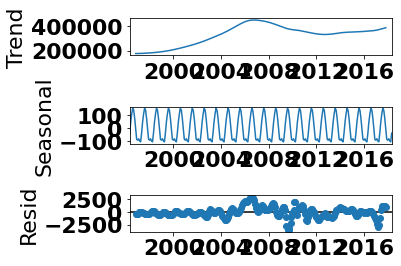

In [28]:
decomposition.plot(plt.gcf().autofmt_xdate())

 - Looking at the decomposition chart, the data appears to follows a general upward  trend as expected. The data is also very seasonal, likely due to the seasonal nature of the real esate market in general. Finally the residuals or 'noise' in the date seems fairly consistent up until around the early 2000's when they start to sharly rise and then drop again around the 2008 recession, and again show a dip around around 2017 before beggining to rise again.   

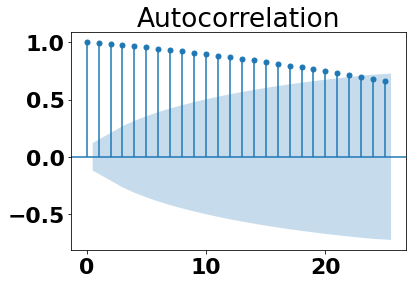

In [29]:
#Plot the autocorrelation function
plot_acf(nj_monthly['value']);

 - Autocorrelation graph shows the data is correlated up to about 20 lags.

### NJ Overall ROI

In [30]:
#Calculate ROI for the state of New Jersey ('96-'18)
get_roi(nj_df)

1996-2018 Return on Investment: 1.27


## Seperate Data into Individual Counties

In [31]:
#Check unique county names
melted_df[melted_df['State'] == 'NJ']['CountyName'].unique()

array(['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic',
       'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer',
       'Morris', 'Atlantic', 'Gloucester', 'Cumberland', 'Warren',
       'Hunterdon', 'Cape May', 'Sussex', 'Salem'], dtype=object)

## Data Exploration

 - Will break the data out into individual counties, plot any interesting findings, as well as calculate county ROI's for analysis.

### Hudson County Analysis

In [32]:
#Create Hudson County dataframe
hudson_df = county_df('Hudson')
hudson_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0
1996-04-01,60599,7093,West New York,NJ,New York,Hudson,215,131700.0
1996-04-01,60594,7087,Union City,NJ,New York,Hudson,320,127300.0


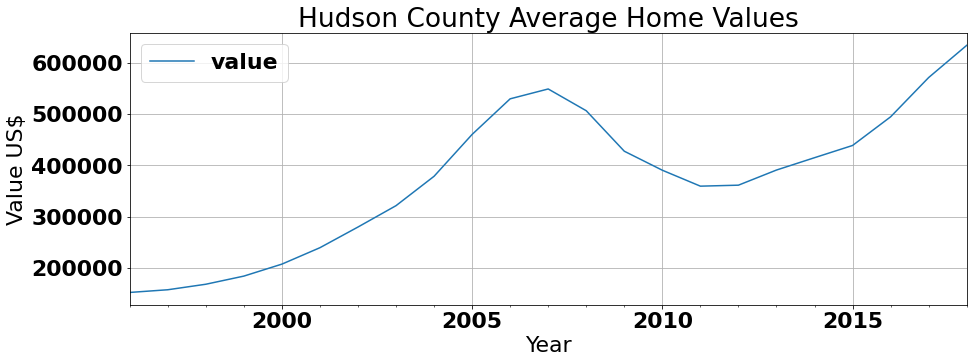

In [65]:
#Plot Hudson County Average Values
plot_values(hudson_df, 'Hudson County Average Home Values')

 - Hudson County appears to have one of the highest county ROI's after analyzing the above graph.

In [34]:
#Check Hudson County ROI
get_roi(hudson_df)

1996-2018 Return on Investment: 3.15


### Monmouth County Analysis

In [35]:
monmouth_df = county_df('Monmouth')
monmouth_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60776,7728,Freehold,NJ,New York,Monmouth,577,200200.0
1996-04-01,60763,7712,Ocean,NJ,New York,Monmouth,1110,159300.0
1996-04-01,60774,7726,Manalapan,NJ,New York,Monmouth,1499,205700.0
1996-04-01,60793,7753,Neptune,NJ,New York,Monmouth,1704,119400.0
1996-04-01,60786,7740,Long Branch,NJ,New York,Monmouth,2483,116100.0


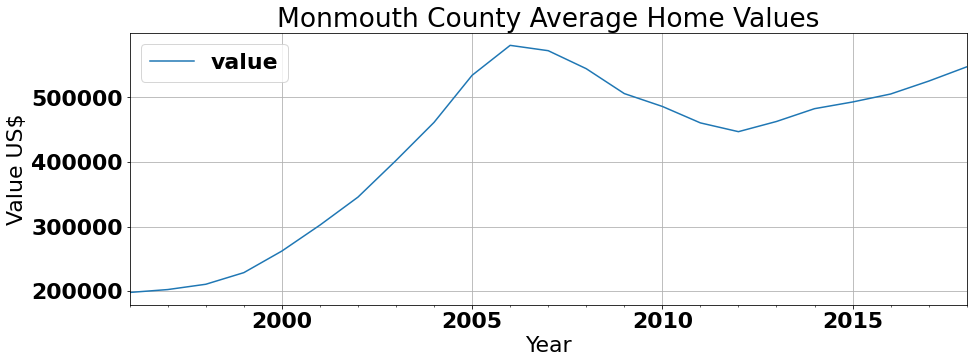

In [66]:
plot_values(monmouth_df, 'Monmouth County Average Home Values')

 - Monmouth County also appears to have one of the highest county ROI's after analyzing the above graph.

In [37]:
#Check Monmouth County ROI
get_roi(monmouth_df)

1996-2018 Return on Investment: 1.76


### Cape May County Analysis

In [38]:
cape_may_df = county_df('Cape May')
cape_may_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61017,8226,Ocean City,NJ,Ocean City,Cape May,3631,182400.0
1996-04-01,61002,8204,Lower,NJ,Ocean City,Cape May,4537,107700.0
1996-04-01,61004,8210,Middle,NJ,Ocean City,Cape May,5878,93300.0
1996-04-01,61034,8260,North Wildwood,NJ,Ocean City,Cape May,6038,89500.0
1996-04-01,61032,8251,Villas,NJ,Ocean City,Cape May,7399,61800.0


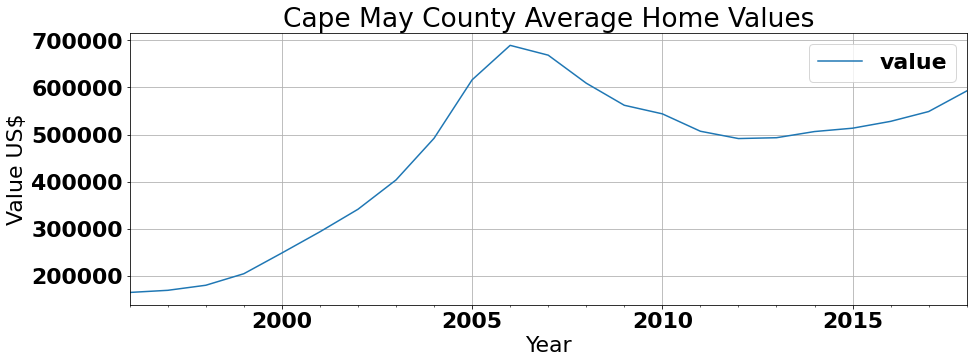

In [67]:
plot_values(cape_may_df, 'Cape May County Average Home Values')

 - Cape May County also appears to have one of the highest county ROI's after analyzing the above graph.

In [40]:
get_roi(cape_may_df)

1996-2018 Return on Investment: 2.61


## County ROI Analysis

 - Will analyze the ROI's for each county in order to determine the top three past ROI counties.

In [41]:
#Run ROI Dictionary function to create dictionary of past ROI's
roi_dict = get_roi_dict(nj_df)

In [42]:
roi_dict

{'Hudson': 3.15,
 'Ocean': 1.54,
 'Middlesex': 1.17,
 'Somerset': 0.97,
 'Monmouth': 1.76,
 'Passaic': 0.98,
 'Essex': 1.63,
 'Camden': 0.82,
 'Bergen': 1.32,
 'Burlington': 0.83,
 'Union': 1.33,
 'Mercer': 1.07,
 'Morris': 1.07,
 'Atlantic': 0.96,
 'Gloucester': 0.77,
 'Cumberland': 0.68,
 'Warren': 0.64,
 'Hunterdon': 0.77,
 'Cape May': 2.61,
 'Sussex': 0.64,
 'Salem': 0.75}

In [43]:
#Use ROI Dictionary to create a dataframe and sort by highest value for analysis
county_roi_df = pd.DataFrame(list(roi_dict.items()),columns = ['County','Return on Investment']) 
county_roi_df.sort_values(by='Return on Investment', ascending=False).reset_index(drop=True)

,County,Return on Investment
0,Hudson,3.15
1,Cape May,2.61
2,Monmouth,1.76
3,Essex,1.63
4,Ocean,1.54
5,Union,1.33
6,Bergen,1.32
7,Middlesex,1.17
8,Mercer,1.07
9,Morris,1.07


### Past ROI Summary

 - Overall the top three ROI NJ counties from 1996-2018 were Hudson County with a 315% ROI, followed by Cape May County at 261%, and finally Monmouth County at 176%. Warren and Sussex County were also tied for last in ROI at 64% each. Going forward with the analysis I would expect the top counties here to possibly level off going forward with a lesser demand at the current high prices for these counties. It will also be interesting to see if the lower counties here turn out to be the highest in terms of furture ROI predicitons based on the fact that there is more room to grow in home value for these counties.  

In [44]:
hudson_yearly = hudson_df['value'].resample(rule='A').mean()
cape_may_yearly = cape_may_df['value'].resample(rule='A').mean()
monmouth_yearly = monmouth_df['value'].resample(rule='A').mean()

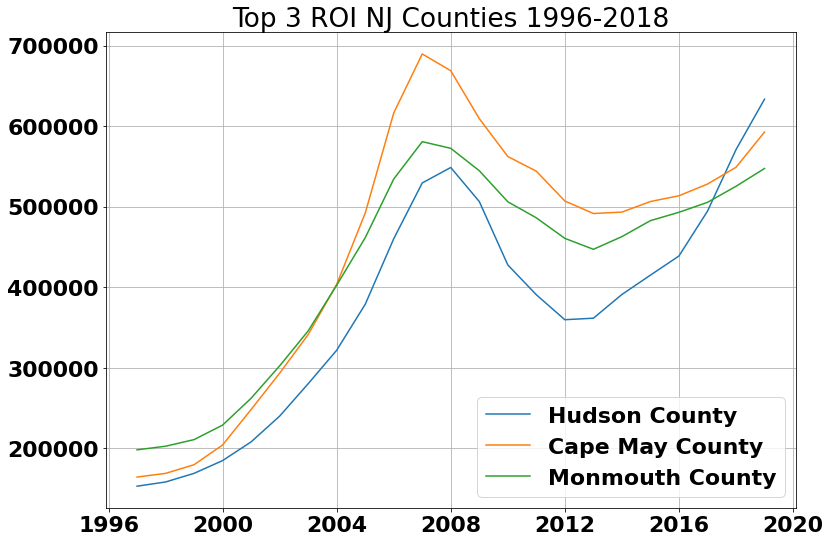

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hudson_yearly, color='tab:blue', label='Hudson County')
ax.plot(cape_may_yearly, color='tab:orange', label='Cape May County')
ax.plot(monmouth_yearly, color='tab:green', label='Monmouth County')
ax.legend()
plt.grid()
plt.title('Top 3 ROI NJ Counties 1996-2018')
fig.tight_layout()

 - Overall the top three ROI counties appear to be following a general upward trend aside from the downturn due to the 2008 economic recession. Hudson county appears to have been hit the hardest by the recession but has since sharly bounced back. Also Cape May County had the overall highest average value close to 700,000 before the recession and did not get hit as hard as Hudson County. Monmouth County started at the highest average value in 1996 but has since been somewhere in the middle of the other two counties. Going forward it will be interesting to see if Cape May will get back to its highest point of 700,000 and whether Hudson County values will continue to sharly rise or will begin to level off.    

## SARIMA Modeling

 - SARIMA models were choosen for the data because the will take into account the seasonality component associated with real estate data. A stepwise fit for each county will be run in order to determine the optimal model order for each. After the optimal order is determined the data will then be fit to the SARIMA model. Predictions will then be made for the next 5 years. Forecasted 5 year ROI will then be analyzed by county in order to determine the top 3 highest ROI counties. 

In [46]:
#Run SARIMA Model function to return dictionary of 5-year forecasted ROI's 
sarima_model_fcast(nj_df)

{'Hudson': 0.1,
 'Ocean': 0.09,
 'Middlesex': 0.22,
 'Somerset': 0.13,
 'Monmouth': -0.03,
 'Passaic': 0.55,
 'Essex': -0.28,
 'Camden': 0.31,
 'Bergen': 0.15,
 'Burlington': 0.29,
 'Union': 0.04,
 'Mercer': 0.36,
 'Morris': 0.15,
 'Atlantic': 0.12,
 'Gloucester': -0.16,
 'Cumberland': -0.17,
 'Warren': 0.28,
 'Hunterdon': 0.07,
 'Cape May': 0.13,
 'Sussex': 0.64,
 'Salem': 1.21}

In [47]:
#Run function to check RMSE of each county model
sarima_model_rmse(nj_df)

{'Hudson': 47456,
 'Ocean': 8026,
 'Middlesex': 17452,
 'Somerset': 9014,
 'Monmouth': 7831,
 'Passaic': 9767,
 'Essex': 19852,
 'Camden': 2259,
 'Bergen': 26715,
 'Burlington': 8035,
 'Union': 9144,
 'Mercer': 10396,
 'Morris': 3106,
 'Atlantic': 6145,
 'Gloucester': 12564,
 'Cumberland': 2499,
 'Warren': 7619,
 'Hunterdon': 8982,
 'Cape May': 26499,
 'Sussex': 1738,
 'Salem': 6334}

 - RMSE's appear to be within a decent range compared to the mean value of each county.

## Forcasted ROI Analysis

 - Will analyze forecasted ROI predictions in order to make business recommendations.

In [48]:
fcast_roi_dict = sarima_model_fcast(nj_df)

In [49]:
#Create dataframe of top forecasted ROI counties for analysis
fcast_roi_df = pd.DataFrame(list(fcast_roi_dict.items()),columns = ['County','Forecasted ROI']) 
fcast_roi_df.sort_values(by='Forecasted ROI', ascending=False).reset_index(drop=True)

,County,Forecasted ROI
0,Salem,1.21
1,Sussex,0.64
2,Passaic,0.55
3,Mercer,0.36
4,Camden,0.31
5,Burlington,0.29
6,Warren,0.28
7,Middlesex,0.22
8,Bergen,0.15
9,Morris,0.15


 - The top three forecasted counties according to the models are Salem at 121%, Sussex at 64%, and Passaic at 55%. 
 
 - The bottom forecasted counties according to the model are Monmouth, Gloucester, Cumberland, and Essex all with negative predicted ROI returns. 

### ROI Past and Future Comparison

In [50]:
roi_comparison = county_roi_df.merge(fcast_roi_df, how='inner')
roi_comparison['ROI Change %'] = roi_comparison['Forecasted ROI'] - roi_comparison['Return on Investment']
roi_comparison.sort_values(by='Forecasted ROI', ascending=False).reset_index(drop=True)

,County,Return on Investment,Forecasted ROI,ROI Change %
0,Salem,0.75,1.21,0.46
1,Sussex,0.64,0.64,0.00
2,Passaic,0.98,0.55,-0.43
3,Mercer,1.07,0.36,-0.71
4,Camden,0.82,0.31,-0.51
5,Burlington,0.83,0.29,-0.54
6,Warren,0.64,0.28,-0.36
7,Middlesex,1.17,0.22,-0.95
8,Bergen,1.32,0.15,-1.17
9,Morris,1.07,0.15,-0.92


 - Looking at the top three counties here, overall Salem county saw a 46% increase in its forecasted ROI compared to past ROI data, indicating that values here are growing at a faster rate than in the past. Sussex county has the same forecasted ROI compared to past ROI, indicating that values are growing at a consistent rate. While Passaic County saw a 43% decrease in ROI compared to its past ROI, this could indicate that while it still shows a high forecasted ROI of 55%, it is not growing as rapidly as in the past.    
 
 - Interestingly Hudson, Cape May, and Monmouth County, the top three ROI counties in the past all have low future forecasted ROI's at 13% and under. This could indicate that these counties may have leveled off in terms of home values and are not strong investments going forward. 

## Top 3 Forecasted ROI NJ Counties

In [53]:
salem_df = county_df('Salem')

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind=array([[ 4.29860730e-01,  9.91717199e-01],
       [-9.66522918e-01, -3.74995507e-01],
       [-1.55649864e-01, -9.13689301e-02],
       [ 4.26971771e+05,  5.27872610e+05]]))` instead of `Series.plot(array([[ 4.29860730e-01,  9.91717199e-01],
       [-9.66522918e-01, -3.74995507e-01],
       [-1.55649864e-01, -9.13689301e-02],
       [ 4.26971771e+05,  5.27872610e+05]]),)`.

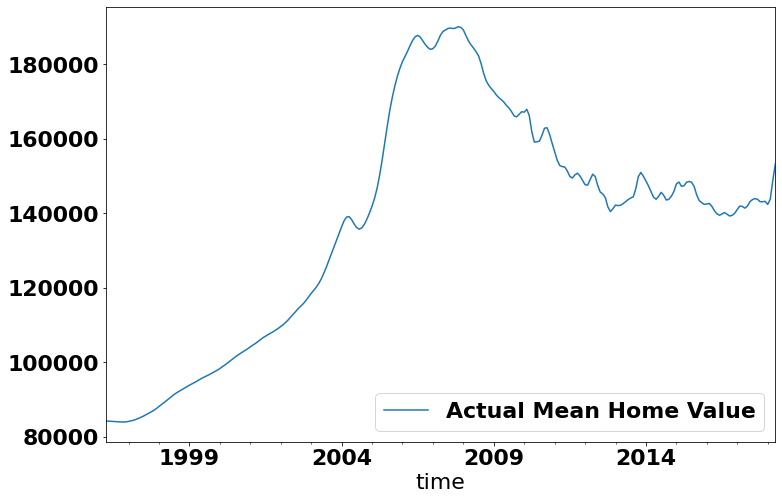

In [78]:
#Plot Salem County 5-year forecast and check RMSE
fcast_plot(salem_df, 'Salem County 5-yr Forecast')

 - The top ROI forecasted NJ county is Salem County with a predicted increase of 121% over the next 5 years. The average initial cost for the county in 2018 is just over 150,000 dollars. While the predicted average value in 2023 is just under 350,000 dollars. The model used predicts average home values within 6,334 dollars of the actual average value.   

(<AxesSubplot:title={'center':'Salem Model Actual vs. Predicated Mean Value'}, xlabel='May 2017 - April 2018', ylabel='Value US$'>,
 <AxesSubplot:title={'center':'Salem Model Actual vs. Predicated Mean Value'}, xlabel='May 2017 - April 2018', ylabel='Value US$'>,
 Text(0.5, 1.0, 'Salem Model Actual vs. Predicated Mean Value'),
 Text(0.5, 0, 'May 2017 - April 2018'),
 Text(0, 0.5, 'Value US$'),
 None)

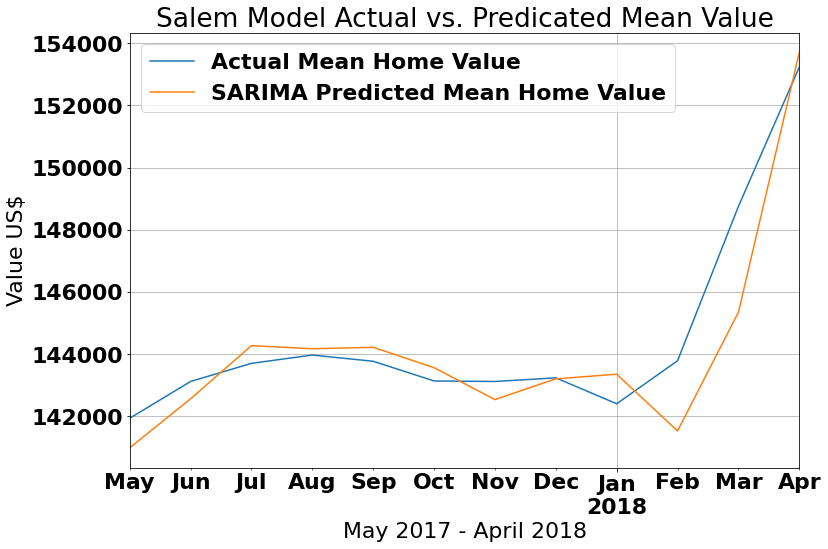

In [55]:
#Check the accuracy of the model 
model_accuracy(salem_df, "Salem Model Actual vs. Predicated Mean Value")

 - Analyzing the above graph comparing the model predictions from May 2017 to April 2018, this model appears to be performing well, aside from being slightly off in predictions between February and April 2018. 

In [57]:
sussex_df = county_df('Sussex')

(<AxesSubplot:title={'center':'Sussex County 5-yr Forecast'}, xlabel='Year', ylabel='Value US$'>,
 <AxesSubplot:title={'center':'Sussex County 5-yr Forecast'}, xlabel='Year', ylabel='Value US$'>,
 None,
 Text(0.5, 1.0, 'Sussex County 5-yr Forecast'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Value US$'))

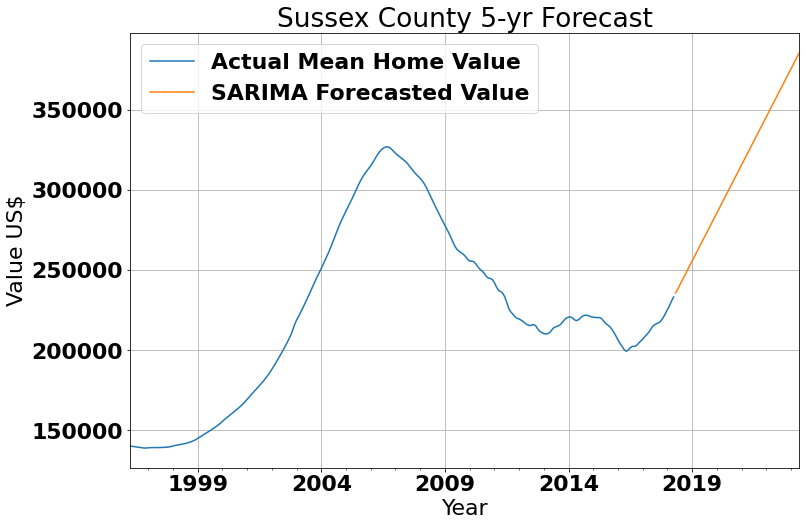

In [58]:
#Plot Sussex County 5-year forecast and check RMSE
fcast_plot(sussex_df, 'Sussex County 5-yr Forecast')

 - The 2nd highest ROI forecasted NJ county is Sussex County with a predicted increase of 64% over the next 5 years. The average initial cost for the county in 2018 is just under 250,000 dollars. While the predicted average value in 2023 is just under 400,000 dollars. The model used predicts average home values within 1,738 dollars of the actual average value.   

(<AxesSubplot:title={'center':'Sussex Model Actual vs. Predicated Mean Value'}, xlabel='May 2017 - April 2018', ylabel='Value US$'>,
 <AxesSubplot:title={'center':'Sussex Model Actual vs. Predicated Mean Value'}, xlabel='May 2017 - April 2018', ylabel='Value US$'>,
 Text(0.5, 1.0, 'Sussex Model Actual vs. Predicated Mean Value'),
 Text(0.5, 0, 'May 2017 - April 2018'),
 Text(0, 0.5, 'Value US$'),
 None)

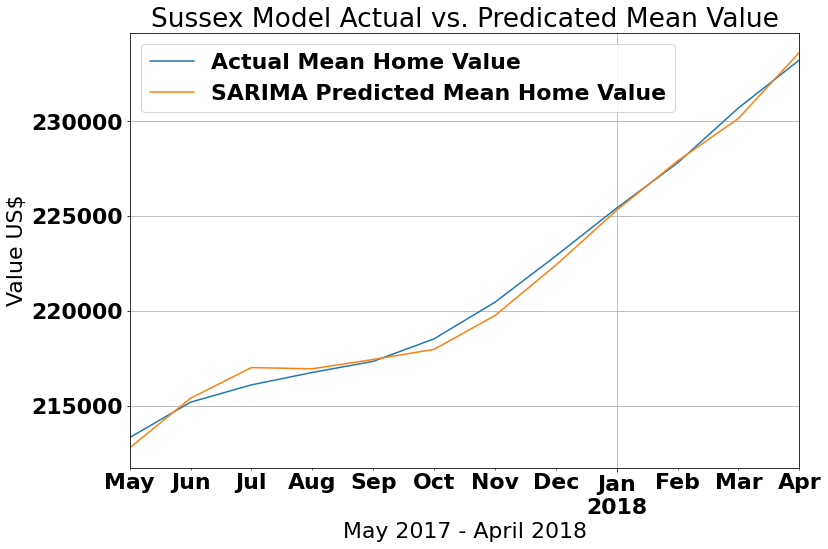

In [59]:
#Check the accuracy of the model
model_accuracy(sussex_df, "Sussex Model Actual vs. Predicated Mean Value")

 - This model appears to be performing well after analyzing the above graph of predictions vs. actual mean value.

In [60]:
passaic_df = county_df('Passaic')

(<AxesSubplot:title={'center':'Passaic County 5-yr Forecast'}, xlabel='Year', ylabel='Value US$'>,
 <AxesSubplot:title={'center':'Passaic County 5-yr Forecast'}, xlabel='Year', ylabel='Value US$'>,
 None,
 Text(0.5, 1.0, 'Passaic County 5-yr Forecast'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Value US$'))

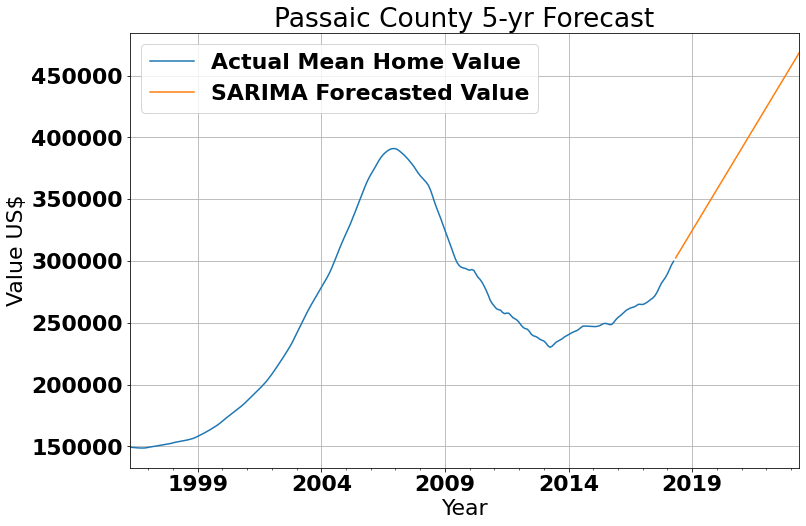

In [61]:
#Plot Passaic County 5-year forecast and check RMSE 
fcast_plot(passaic_df, 'Passaic County 5-yr Forecast')

 - The 3rd ROI forecasted NJ county is Passaic County with a predicted increase of 55% over the next 5 years. The average initial cost for the county in 2018 is about 300,000 dollars. While the predicted average value in 2023 is about 475,000 dollars. The model used predicts average home values within 9,767 dollars of the actual average value.   

(<AxesSubplot:title={'center':'Passaic Model Actual vs. Predicated Mean Value'}, xlabel='May 2017 - April 2018', ylabel='Value US$'>,
 <AxesSubplot:title={'center':'Passaic Model Actual vs. Predicated Mean Value'}, xlabel='May 2017 - April 2018', ylabel='Value US$'>,
 Text(0.5, 1.0, 'Passaic Model Actual vs. Predicated Mean Value'),
 Text(0.5, 0, 'May 2017 - April 2018'),
 Text(0, 0.5, 'Value US$'),
 None)

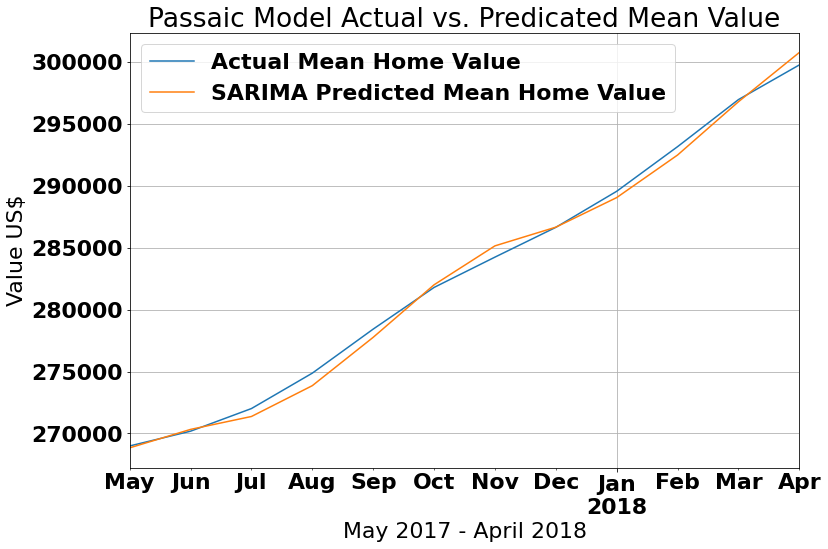

In [62]:
#Check the accuracy of the model
model_accuracy(passaic_df, "Passaic Model Actual vs. Predicated Mean Value")

 - This model appears to be performing well after analyzing the above graph of predictions vs. actual mean value.

## Business Reccomendations/Conclusion

 - Overall business recommendations are as follows:
 
 1. Invest in Salem, Sussex, and Passaic County for the highest forecasted ROI returns. 
 2. Strongly reccommend to invest in Salem County due to its lowest initial cost of just over 150,000 dollars along with the overall highest forecasted ROI of 121%, almost double the next highest forecast.
 3. Recommend avoiding past top ROI counties including Hudson, Cape May, and Monmouth County. Despite the large past ROI data from these counties they may have leveled off in terms of value and likely will not be good investment options going forward.

## Future Work

 - Going forward future work on this project could include:
 
     1. Add another model type such as a RNN in order to compare its forecasts with the SARIMA models used here and check for similarities/differences between the models.
     
     2. Go deeper into the analysis by modeling the top counties by their cities in order to determine the top ROI cities within the counties thereby providing even more targeted recommendations with regard to where to invest.
     
     3. Take into account another evaluation metric along with ROI such as risk in order to provide more detailed investment recommendations.